# Sect 46: Tuning Neural Networks

- Study Group: 02-12-20
- online-ds-ft-100719

## Learning Objectives

- learn how to use GridSearchCV with neural networks
- how to create your own custom scorer and why you'd want to 
- set up a Timer and email notifications for your gridsearch

## Questions/Comments?
-

## Activation Functions
- https://dashee87.github.io/deep%20learning/visualising-activation-functions-in-neural-networks/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def sigmoid(x, derivative=False):
    f = 1 / (1 + np.exp(-x))
    if (derivative == True):
        return f * (1 - f)
    return f

def tanh(x, derivative=False):
    f = np.tanh(x)
    if (derivative == True):
        return (1 - (f ** 2))
    return np.tanh(x)

def relu(x, derivative=False):
    f = np.zeros(len(x))
    if (derivative == True):
        for i in range(0, len(x)):
            if x[i] > 0:
                f[i] = 1  
            else:
                f[i] = 0
        return f
    for i in range(0, len(x)):
        if x[i] > 0:
            f[i] = x[i]  
        else:
            f[i] = 0
    return f

def leaky_relu(x, leakage = 0.05, derivative=False):
    f = np.zeros(len(x))
    if (derivative == True):
        for i in range(0, len(x)):
            if x[i] > 0:
                f[i] = 1  
            else:
                f[i] = leakage
        return f
    for i in range(0, len(x)):
        if x[i] > 0:
            f[i] = x[i]  
        else:
            f[i] = x[i]* leakage
    return f

def arctan(x, derivative=False):
    if (derivative == True):
        return 1/(1+np.square(x))
    return np.arctan(x)

def plot_activation(fn):
    z = np.arange(-10, 10, 0.2)
    y = fn(z)
    dy = fn(z, derivative=True)
    fig,ax=plt.subplots(figsize=(6,4))
    ax.set_title(f'{fn.__name__}')
    ax.set(xlabel='Input',ylabel='Output')
    ax.axhline(color='gray', linewidth=1,)
    ax.axvline(color='gray', linewidth=1,)
    ax.plot(z, y, 'r', label='original (y)')
    ax.plot(z, dy, 'b', label='derivative (dy)')
    ax.legend();
    plt.show()

## Plot activation functions
# act_funcs = [sigmoid,tanh,arctan,relu,leaky_relu]
# [plot_activation(fn) for fn in act_funcs]

## Image Classification with MLPs - Lab

In [1]:
from fsds_100719.imports import *

import keras
from keras.datasets import mnist

from keras import models, layers,optimizers
from keras.models import Sequential
from keras.layers import Dense#,Dropout

from keras.utils import to_categorical

fsds_1007219  v0.7.4 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


['[i] Pandas .iplot() method activated.']


Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(f'X_train.shape:\t{X_train.shape}')
print(f'X_test.shape:\t{X_test.shape}')
print()

X_train.shape:	(60000, 28, 28)
X_test.shape:	(10000, 28, 28)



[Text(0.5, 1.0, 'Image #17315:  Label=2')]

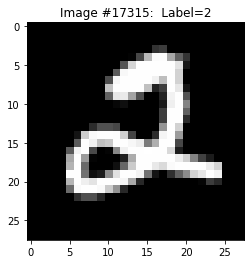

In [3]:
## Visualize random image
i = np.random.choice(list(range(len(X_train))))
sample_image = X_train[i]
sample_label = y_train[i]

title = f"Image #{i}:  Label={sample_label}"
plt.imshow(sample_image, cmap='gray')

ax= plt.gca()
ax.set(title=title)


In [4]:
## Print out image shapes and data shapes
print(sample_image.shape)
print(f"X_train.shape={X_train.shape}")
print(f"X_test.shape={X_test.shape}")
print(sample_image.shape[0]*sample_image.shape[1])

(28, 28)
X_train.shape=(60000, 28, 28)
X_test.shape=(10000, 28, 28)
784


In [5]:
## SAVE SHAPES FOR EASY ACCESS LATE
X_shapes = dict(X_train=X_train.shape,
                X_test=X_test.shape,
               y_train=y_train.shape,
               y_test=y_test.shape,
               image=sample_image.shape,
                image_flat = sample_image.shape[0]*sample_image.shape[1]
               )
X_shapes

{'X_train': (60000, 28, 28),
 'X_test': (10000, 28, 28),
 'y_train': (60000,),
 'y_test': (10000,),
 'image': (28, 28),
 'image_flat': 784}

> ***We can interpret these numbers as saying "X_train consists of 60,000 images that are 28x28". We'll need to reshape them from (28, 28), a 28x28 matrix, to (784,), a 784-element vector. However, we need to make sure that the first number in our reshape call for both X_train and X_test still correspond to the number of observations we have in each.***

In [6]:
shapes = list(sample_image.shape)
shapes

[28, 28]

In [7]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_shapes = dict(X_train=X_train.shape,
               X_test=X_test.shape,
               y_train=y_train.shape,
                y_test=y_test.shape,
               image=sample_image.shape,
               image_unrow = sample_image.shape[0]*sample_image.shape[1],)

print(X_shapes['X_train'])
print(X_shapes['image_unrow'])

(60000, 28, 28)
784


### Preparing Targets

- This is a **Multiclass Classification** problem.
    - we need to One-Hot Encode our labels
    - `keras.utils.to_categorical`
    
- For multi classification:
    - good final activation function is softmax
    - categorical_crossentytropu


In [8]:
#  reshape and convert astype('float32') so that we convert our data from type uint8 to float32
X_train = X_train.reshape(X_shapes['X_train'][0], X_shapes['image_unrow']).astype('float32')
X_test = X_test.reshape(X_shapes['X_test'][0], X_shapes['image_unrow']).astype('float32')

## normalizing data 
X_train /= 255
X_test /= 255

y_train_orig = y_train.copy()
y_test_orig = y_test.copy()

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(f"y_train original shape = {y_train_orig.shape}")
print(f"y_train to_categorical shape = {y_train.shape}")

y_train original shape = (60000,)
y_train to_categorical shape = (60000, 10)


In [9]:
## build network

## Model 3
model3= models.Sequential()
model3.add( 
    Dense(64, activation='relu', input_shape=(X_shapes['image_unrow'],) ))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(10, activation='softmax'))

compile_kws=dict(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model3.compile(**compile_kws)

model3.summary()
# model.summary()

model=model3

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


In [16]:
## Train network
history = model.fit(X_train, y_train, batch_size=64, epochs= 5,
                   validation_data=(X_test,y_test))

y_hat_test = model.predict_classes(X_test)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1s 24us/step - loss: 0.2410 - accuracy: 0.9313 - val_loss: 0.2240 - val_accuracy: 0.9364
Epoch 2/5
60000/60000 [==============================] - 2s 25us/step - loss: 0.2235 - accuracy: 0.9359 - val_loss: 0.2100 - val_accuracy: 0.9384
Epoch 3/5
60000/60000 [==============================] - 2s 26us/step - loss: 0.2080 - accuracy: 0.9403 - val_loss: 0.1986 - val_accuracy: 0.9407
Epoch 4/5
60000/60000 [==============================] - 1s 25us/step - loss: 0.1946 - accuracy: 0.9440 - val_loss: 0.1884 - val_accuracy: 0.9439
Epoch 5/5
60000/60000 [==============================] - 1s 25us/step - loss: 0.1833 - accuracy: 0.9471 - val_loss: 0.1767 - val_accuracy: 0.9476


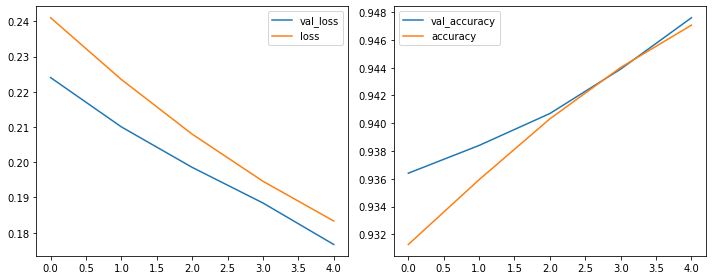

In [17]:
def plot_keras_history(history,figsize=(10,4),subplot_kws={}):
    if hasattr(history,'history'):
        history=history.history
    #     history = results.history
    fig,axes=plt.subplots(ncols=2,figsize=figsize,**subplot_kws)
    
    ax=axes[0]
    ax.plot(history['val_loss'],label='val_loss')
    ax.plot(history['loss'], label='loss')
    ax.legend()
    
    ax=axes[1]
    ax.plot(history['val_accuracy'],label='val_accuracy')
    ax.plot(history['accuracy'], label='accuracy')

    ax.legend()
    
    plt.tight_layout()
    plt.show()
plot_keras_history(history)

In [39]:
import sklearn.metrics as metrics
def plot_confusion_matrix(conf_matrix, classes = None, normalize=True,
                          title='Confusion Matrix', cmap="Blues",
                          print_raw_matrix=False,
                          fig_size=(7,8)):
    """Check if Normalization Option is Set to True. 
    If so, normalize the raw confusion matrix before visualizing
    #Other code should be equivalent to your previous function.
    Note: Taken from bs_ds and modified
    - Can pass a tuple of (y_true,y_pred) instead of conf matrix.
    """
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    import sklearn.metrics as metrics
    
    ## make confusion matrix if given tuple of y_true,y_pred
    if isinstance(conf_matrix, tuple):
        y_true = conf_matrix[0].copy()
        y_pred = conf_matrix[1].copy()
        
        if y_true.ndim>1:
            y_true = y_true.argmax(axis=1)
        if y_pred.ndim>1:
            y_pred = y_pred.argmax(axis=1)
        cm = metrics.confusion_matrix(y_true,y_pred)
    else:
        cm = conf_matrix
        
    ## Generate integer labels for classes
    if classes is None:
        classes = list(range(len(cm)))  
        
    ## Normalize data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt='.2f'
    else:
        fmt= 'd'
        
        
    fontDict = {
        'title':{
            'fontsize':16,
            'fontweight':'semibold',
            'ha':'center',
            },
        'xlabel':{
            'fontsize':14,
            'fontweight':'normal',
            },
        'ylabel':{
            'fontsize':14,
            'fontweight':'normal',
            },
        'xtick_labels':{
            'fontsize':10,
            'fontweight':'normal',
    #             'rotation':45,
            'ha':'right',
            },
        'ytick_labels':{
            'fontsize':10,
            'fontweight':'normal',
            'rotation':0,
            'ha':'right',
            },
        'data_labels':{
            'ha':'center',
            'fontweight':'semibold',

        }
    }

    # Create plot
    fig,ax = plt.subplots(figsize=fig_size)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,**fontDict['title'])
    plt.colorbar()

    tick_marks = classes#np.arange(len(classes))


    plt.xticks(tick_marks, classes, **fontDict['xtick_labels'])
    plt.yticks(tick_marks, classes,**fontDict['ytick_labels'])

    # Determine threshold for b/w text
    thresh = cm.max() / 2.

    # fig,ax = plt.subplots()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 color='darkgray',**fontDict['data_labels']) #color="white" if cm[i, j] > thresh else "black"

    plt.tight_layout()
    plt.ylabel('True label',**fontDict['ylabel'])
    plt.xlabel('Predicted label',**fontDict['xlabel'])

    if print_raw_matrix:
        print_title = 'Raw Confusion Matrix Counts:'
        print('\n',print_title)
        print(conf_matrix)


    fig = plt.gcf()
    return fig

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.94      0.95      1032
           3       0.92      0.95      0.94      1010
           4       0.93      0.96      0.95       982
           5       0.94      0.91      0.92       892
           6       0.95      0.95      0.95       958
           7       0.95      0.94      0.95      1028
           8       0.94      0.92      0.93       974
           9       0.95      0.92      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



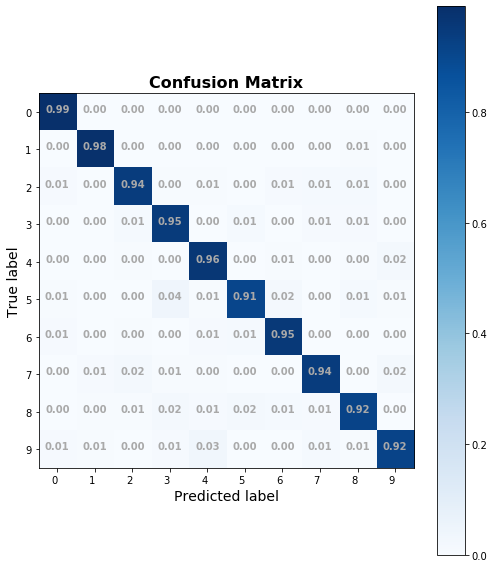

In [36]:
plot_confusion_matrix((y_test,y_hat_test));
print(metrics.classification_report(y_test.argmax(axis=1),y_hat_test))

In [23]:
print(y_test.shape)
print(y_hat_test.shape)

(10000, 10)
(10000,)


In [25]:
y_test_fix = y_test.argmax(axis=1)
y_test_fix.shape

(10000,)

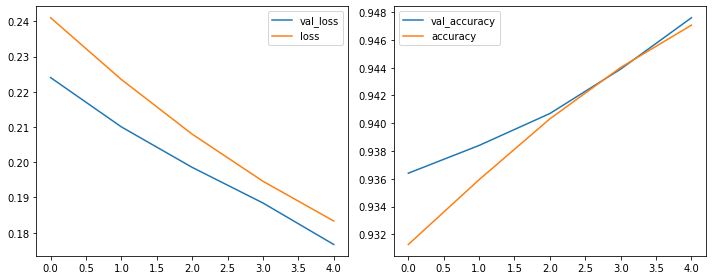

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.94      0.95      1032
           3       0.92      0.95      0.94      1010
           4       0.93      0.96      0.95       982
           5       0.94      0.91      0.92       892
           6       0.95      0.95      0.95       958
           7       0.95      0.94      0.95      1028
           8       0.94      0.92      0.93       974
           9       0.95      0.92      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



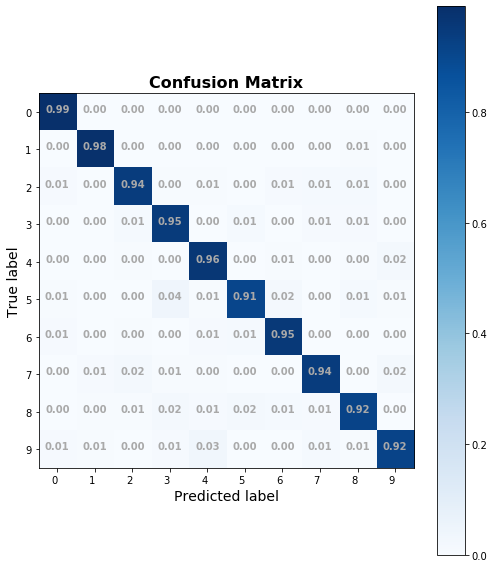

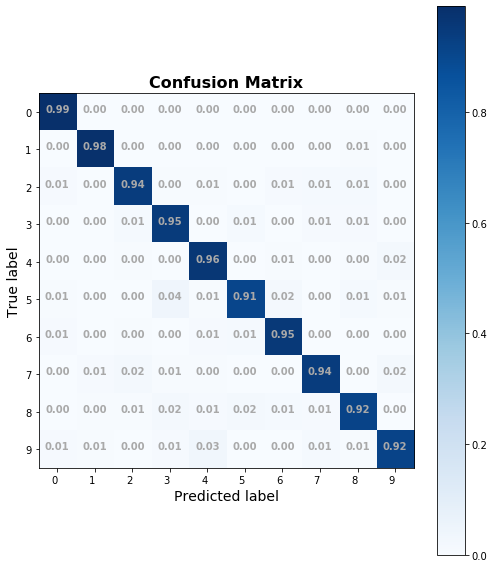

In [59]:
def evaluate_model(y_true, y_pred,history=None):

    if y_true.ndim>1:
        y_true = y_true.argmax(axis=1)
    if y_pred.ndim>1:
        y_pred = y_pred.argmax(axis=1)   
        
    if history is not None:
        plot_keras_history(history)
    
    print(metrics.classification_report(y_true,y_pred))
    
    fig = plot_confusion_matrix((y_true,y_pred))
    display(fig)
    
evaluate_model(y_test,y_hat_test,history=history)

In [28]:
all(y_test_fix==y_test_orig)

True

# HyperParameter Tuning with Keras

Original Source: https://chrisalbon.com/deep_learning/keras/tuning_neural_network_hyperparameters/
<br><br>

- To use `GridSearchCV` or other similar functions in scikit-learn with a Keras neural network, we need to wrap our keras model in `keras.wrappers.scikit_learn`'s `KerasClassifier` and `KerasRegressor`.
1. To do this, we need to write a build function(`build_fn`) that creates our model such as `create_model`.
    - This function must accept whatever parameters you wish to tune. 
    - It also must have a default argument for each parameter.
    - This function must Return the model (and only the model)
    

```python

## Define the build function
def create_model(n_units=(50,25,7), activation='relu',final_activation='softmax',
                optimizer='adam'):
    
    ## Pro tip:save the local variables now so you can print out the parameters used to create the model.
    params_used = locals()
    print('Parameters for model:\n',params_used)
    
   
    from keras.models import Sequential
    from keras import layers
    
    model=Sequential()
    model.add(layers.Dense(n_units[0], activation=activation, input_shape=(2000,)))
    model.add(layers.Dense(n_units[1], activation=activation))
    model.add(layers.Dense(n_units[2], activation=final_activation))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
    
    display(model.summary())
    return model 
```    

2. We then create out model using the Keras wrapper:

```python
from keras.wrappers.scikit_learn import KerasClassifier
neural_network =  KerasClassifier(build_fn=create_model,verbose=1)
```

3. Now, set up the hyperparameter space for grid search. (Remember, your `create_model` function must accept the parameter you want to tune)

```python
params_to_test = {'n_units':[(50,25,7),(100,50,7)],
                  'optimizer':['adam','rmsprop','adadelta'],
                  'activation':['linear','relu','tanh'],
                  'final_activation':['softmax']}
```

4. Now instantiate your GridSearch function

```python
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=neural_network,param_grid=params_to_test)
grid_result = grid.fit(X_train, y_train)
best_params = grid_result.best_params_
```
5. And thats it!

In [80]:
def build_model(optimizer='sgd',act_func='relu',verbose=True):
#     vars = locals()

#     dashes = '---'*20
#     print('\n\n')
#     print(dashes)
#     now = pd.datetime.now()
#     print(now.strftime('%m/%d/%Y-%T'))
#     print(vars)    
#     print('---'*20)

        
    model3= models.Sequential()
    model3.add( 
        Dense(64, activation=act_func, input_shape=(X_shapes['image_unrow'],) ))
    model3.add(Dense(32, activation=act_func))
    model3.add(Dense(10, activation='softmax'))

    compile_kws=dict(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model3.compile(**compile_kws)
    
    if verbose:
        display(model3.summary())
    # model.summary()
    return model3
model = build_model()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 64)                50240     
_________________________________________________________________
dense_116 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_117 (Dense)            (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


None

In [81]:
class Timer():
    def __init__(self, start=True,time_fmt='%m/%d/%y - %T'):
        import tzlocal
        import datetime as dt
        
        self.tz = tzlocal.get_localzone()
        self.fmt= time_fmt
        self._created = dt.datetime.now(tz=self.tz)
        
        if start:
            self.start()
            
    def get_time(self):
        import datetime as dt
        return dt.datetime.now(tz=self.tz)

        
    def start(self,verbose=True):
        self._laps_completed = 0
        self.start = self.get_time()
        if verbose: 
            print(f'[i] Timer started at {self.start.strftime(self.fmt)}')
    
    def stop(self, verbose=True):
        self._laps_completed += 1
        self.end = self.get_time()
        self.elapsed = self.end -  self.start
        if verbose: 
            print(f'[i] Timer stopped at {self.end.strftime(self.fmt)}')
            print(f'  - Total Time: {self.elapsed}')
            
timer = Timer()
import time
timer.stop()

[i] Timer started at 02/12/20 - 13:30:47
[i] Timer stopped at 02/12/20 - 13:30:47
  - Total Time: 0:00:00.000237


In [82]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import RMSprop, Adam

classifier =  KerasClassifier(build_fn=build_model,verbose=1)
leaky_relu = layers.advanced_activations.LeakyReLU()
rms= RMSprop(learning_rate=0.001, rho=0.9)
params = {'optimizer':['sgd',rms],
         'act_func':['relu',leaky_relu],
         'batch_size':[64,128],
          'epochs':[5]}

grid = GridSearchCV(estimator=classifier,param_grid=params,
                   scoring='accuracy')

timer = Timer()

grid.fit(X_train,y_train)
timer.stop()

print(grid_search.best_params_)

[i] Timer started at 02/12/20 - 13:30:48
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_118 (Dense)            (None, 64)                50240     
_________________________________________________________________
dense_119 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_120 (Dense)            (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/5
48000/48000 [==============================] - 2s 41us/step - loss: 1.2221 - accuracy: 0.6659
Epoch 2/5
48000/48000 [==============================] - 2s 35us/step - loss: 0.4481 - accuracy: 0.8777 0s - loss:
Epoch 3/5
48000/48000 [==============================] - 2s 37us/step - loss: 0.3607 - accuracy: 0.8981
Epoch 4/5
48000/48000 [==============================] - 2s 40us/step - loss: 0.3206 - accuracy: 0.9087
Epoch 5/5
12000/12000 [==============================] - 1s 62us/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

> ***Ruh Roh! It doesn't seem to want to work with our data. Thats due to the scoring functions in sklearn not accepting y_data with ndim >1***



## HOW TO: Custom Scoring Functions

1. **Why would you do this?**
    1. You may want to use a metric that isn't available in sklearn. 
        - In the included `my_custom_scorer` function, I take the accuracy of each class's predictions from the diagonal of a normalized confusion matrix. 
        - I then calculate the mean of those 3 class accuracies, which is the `score` that is returned to the gridsearch. 
        
    2. You may want to add a printout or display to the scoring function so you can see the results as the search is going.
<br><br>
2. **How do you do write your own?**
    1. Define your custom scoring function.
        - It must accept `y_true`,`y_pred`
        - It must return a value to maximize. (like accuracy)
    2. You can add print or display commands to have the scoring function report the current results as the gridsearch is still going.
        - If you combine this with the example `create_model` function above that includes the `vars=locals(); print(vars)` command, then gridsearch will display:
            1. the parameters of each model (each time the `create_model` function is called.
            2. The score of each model, including a confusion matrix figure (each time it calls `my_custom_scorer`).
        
```python
def my_custom_scorer(y_true,y_pred):
    """My custom score function to use with sklearn's GridSearchCV
    Maximizes the average accuracy per class using a normalized confusion matrix"""
    from sklearn.metrics import confusion_matrix
    import numpy as np
    import functions_combined_BEST as ji    

    ## Flatten one-hot encoded target columns into 1 column for sklearn functions
    if y_true.ndim>1 or y_pred.ndim>1:
        
        ## reduce dimensions of y_train and y_test
        if y_true.ndim>1:            
            y_true = y_true.argmax(axis=1)
        
        if y_pred.ndim>1:
            y_pred = y_pred.argmax(axis=1)

    
     # Get confusion matrx
    cm = confusion_matrix(y_true, y_pred)

    # Normalize confusion matrix
    cm_norm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]

    ## Get diagonals for class accuracy
    diag = cm_norm.diagonal()
    
    # Get the mean of the diagonal values
    score = np.mean(diag)
    
    ## Display Results for the User
    print(f'Mean Class Accuracy = {score}')
    print(f'Class Accuracy Values:')
    print(diag)    

    ## Plot the confusion matrix.
    ji.plot_confusion_matrix(cm,normalize=True)

    # return the score 
    return score
```        
        
        
3. **How do you use it?**
    - When instantiating GridSearchCV pass your function as the `scoring=` parameter, wrapped in the  `sklearn.metrics.make_scorer` function.
  

```python
## Using custom scoring function
from sklearn.metrics import make_scorer

grid = GridSearchCV(estimator=neural_network, 
                    param_grid=params_to_test,
                   scoring=make_scorer(my_custom_scorer))
                    
grid_result = grid.fit(X_train, y_train)
```

In [75]:
[k for k in locals().keys() if '_' not in k]

['In',
 'Out',
 'exit',
 'quit',
 'clear',
 'fs',
 'pd',
 'np',
 'mpl',
 'plt',
 'sns',
 'dp',
 'cf',
 'keras',
 'mnist',
 'models',
 'layers',
 'optimizers',
 'Sequential',
 'Dense',
 'i',
 'title',
 'ax',
 'shapes',
 'model3',
 'model',
 'history',
 'metrics',
 'Timer',
 'timer',
 'time',
 'KerasClassifier',
 'GridSearchCV',
 'RMSprop',
 'Adam',
 'classifier',
 'rms',
 'params',
 'grid',
 'gmail',
 'parameters']

In [70]:
from sklearn.metrics import make_scorer
def my_custom_scorer(y_true,y_pred,verbose=True):#,scoring='accuracy',verbose=True):
    """My custom score function to use with sklearn's GridSearchCV
    Maximizes the average accuracy per class using a normalized confusion matrix"""

    import sklearn.metrics as metrics
    from sklearn.metrics import confusion_matrix
    import numpy as np

    ## reduce dimensions of y_train and y_test
    if y_true.ndim>1:            
        y_true = y_true.argmax(axis=1)

    if y_pred.ndim>1:
        y_pred = y_pred.argmax(axis=1)
        
    evaluate_model(y_true,y_pred)

    return metrics.accuracy_score(y_true,y_pred)

[i] Timer started at 02/12/20 - 13:27:43
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_98 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_99 (Dense)             (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/5
48000/48000 [==============================] - 2s 42us/step - loss: 1.1172 - accuracy: 0.6948
Epoch 2/5
48000/48000 [==============================] - 2s 37us/step - loss: 0.4323 - accuracy: 0.8803 0s - los - ETA: 0s - loss: 0.4334 - accuracy: 0.
Epoch 3/5
48000/48000 [==============================] - 2s 36us/step - loss: 0.3473 - accuracy: 0.9014
Epoch 4/5
48000/48000 [==============================] - 2s 36us/step - loss: 0.3090 - accuracy: 0.9119
Epoch 5/5
12000/12000 [==============================] - 1s 58us/step



------------------------------------------------------------
02/12/2020-13:27:55
{'verbose': True, 'y_pred': array([5, 0, 4, ..., 2, 8, 3]), 'y_true': array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}
------------------------------------------------------

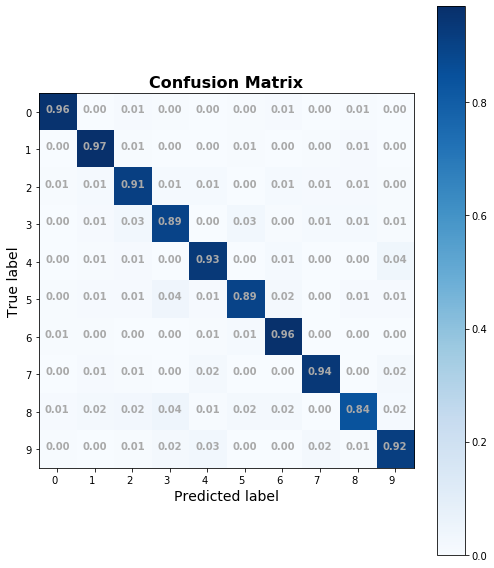

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 64)                50240     
_________________________________________________________________
dense_101 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_102 (Dense)            (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/5
48000/48000 [==============================] - 2s 43us/step - loss: 1.0555 - accuracy: 0.7092
Epoch 2/5
48000/48000 [==============================] - 2s 34us/step - loss: 0.4197 - accuracy: 0.8846
Epoch 3/5
48000/48000 [==============================] - 2s 32us/step - loss: 0.3446 - accuracy: 0.9019
Epoch 4/5
48000/48000 [==============================] - 2s 35us/step - loss: 0.3079 - accuracy: 0.9122
Epoch 5/5
12000/12000 [==============================] - 1s 57us/step



------------------------------------------------------------
02/12/2020-13:28:07
{'verbose': True, 'y_pred': array([7, 4, 6, ..., 3, 9, 4]), 'y_true': array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}
------------------------------------------------------------
              precision    recall  f1-scor

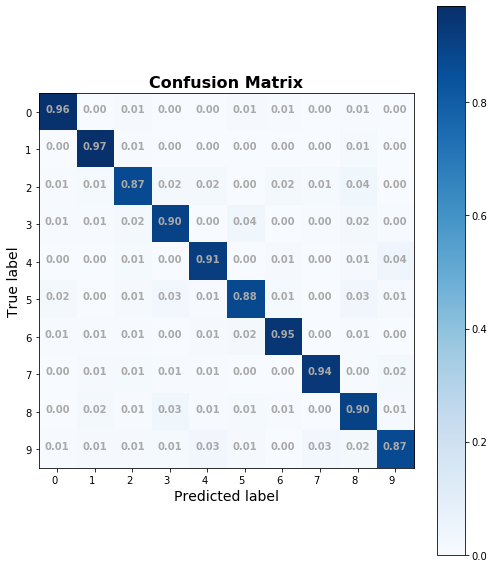

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 64)                50240     
_________________________________________________________________
dense_104 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_105 (Dense)            (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/5
48000/48000 [==============================] - 2s 44us/step - loss: 1.0870 - accuracy: 0.7127
Epoch 2/5
48000/48000 [==============================] - 2s 35us/step - loss: 0.4254 - accuracy: 0.8809
Epoch 3/5
48000/48000 [==============================] - 2s 34us/step - loss: 0.3476 - accuracy: 0.8994 
Epoch 4/5
48000/48000 [==============================] - 2s 35us/step - loss: 0.3106 - accuracy: 0.9101
Epoch 5/5
12000/12000 [==============================] - 1s 57us/step



------------------------------------------------------------
02/12/2020-13:28:19
{'verbose': True, 'y_pred': array([8, 5, 8, ..., 5, 7, 0]), 'y_true': array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)}
------------------------------------------------------------
              precision    recall  f1-sco

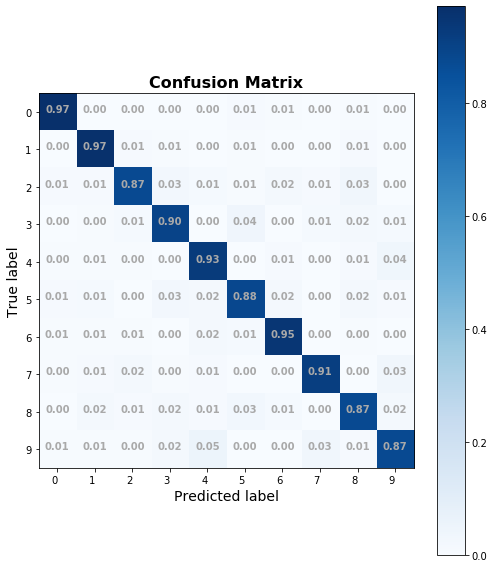

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 64)                50240     
_________________________________________________________________
dense_107 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_108 (Dense)            (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/5
48000/48000 [==============================] - 2s 41us/step - loss: 1.1417 - accuracy: 0.6733
Epoch 2/5
48000/48000 [==============================] - 2s 34us/step - loss: 0.4372 - accuracy: 0.8834
Epoch 3/5
42624/48000 [=========================>....] - ETA: 0s - loss: 0.3516 - accuracy: 0.9005

KeyboardInterrupt: 

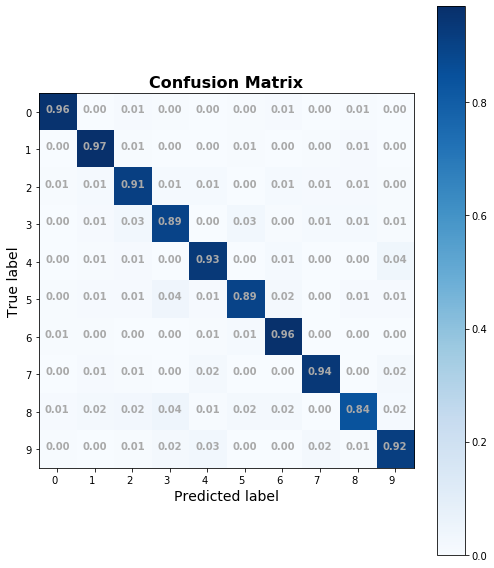

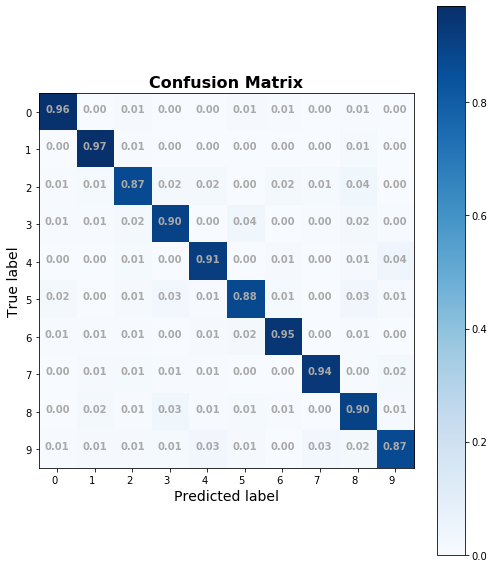

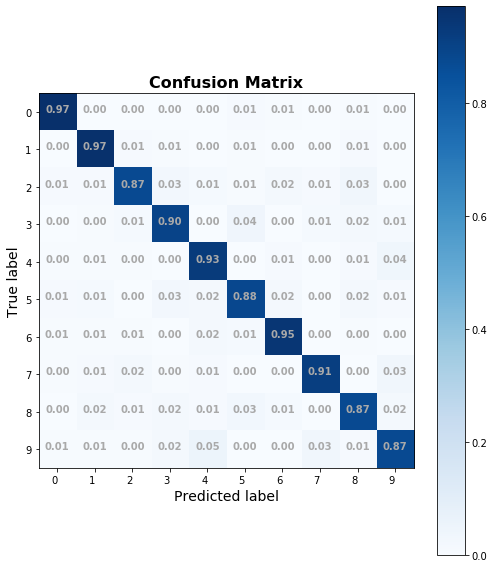

In [71]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import RMSprop, Adam

classifier =  KerasClassifier(build_fn=build_model,verbose=1)
leaky_relu = layers.advanced_activations.LeakyReLU()
rms= RMSprop(learning_rate=0.001, rho=0.9)
params = {'optimizer':['sgd',rms],
         'act_func':['relu',leaky_relu],
         'batch_size':[64,128],
          'epochs':[5]}

grid = GridSearchCV(estimator=classifier,param_grid=params,
                   scoring=make_scorer(my_custom_scorer))##'accuracy')

timer = Timer()

grid.fit(X_train,y_train)
timer.stop()

print(grid_search.best_params_)

## ADDING EMAIL NOTIFICATIONS

In [ ]:
def get_secret_password(file='/Users/jamesirving/.secret/gmail.json'):
    with open(file) as file:
        import json
        gmail = json.loads(file.read())
    # email_notification()
    print(gmail.keys())
    return gmail


In [62]:
gmail = get_secret_password()

dict_keys(['username', 'password'])


In [63]:
def email_notification(password_obj=None,subject='GridSearch Finished',msg='The GridSearch is now complete.'):
    """Sends email notification from gmail account using previously encrypyted password  object (an instance
    of EncrypytedPassword). 
    Args:
        password_obj (EncryptedPassword object): EncryptedPassword object with username/password.
        subject (str):Text for subject line.
        msg (str): Text for body of email. 

    Returns:
        Prints `Email sent!` if email successful. 
    """
#     ## Display instructions if no password_obj 
#     if password_obj is None:
#         print('Must pass an EncrypytedPassword object.')
#         print('>> pwd_obj = EncryptedPassword(username="my_username",password="my_password")')
#         print('>> send_email(encrypted_password_obj=pwd_obj)')
#         raise Exception('Must pass an EncryptedPassword.')
    if isinstance(password_obj,dict):
        gmail_user = password_obj['username']
        gmail_password = password_obj['password']
    else:
        
        ## Get username and password from password_obj
        gmail_user = password_obj.username
        gmail_password = password_obj._password_
        
    
    # import required packages
    import smtplib
    from email.mime.multipart import MIMEMultipart
    from email.mime.text import MIMEText
    from email import encoders
    

    ## WRITE EMAIL
    message = MIMEMultipart()
    message['Subject'] =subject
    message['To'] = gmail_user
    message['From'] = gmail_user
    body = msg
    message.attach(MIMEText(body,'plain'))
    text_message = message.as_string()


    # Send email request
    try:
        with  smtplib.SMTP_SSL('smtp.gmail.com',465) as server:
            
            server.login(gmail_user,gmail_password)
            server.sendmail(gmail_user,gmail_user, text_message)
            server.close()
            print('Email sent!')
        
    except Exception as e:
        print(e)
        print('Something went wrong')
        
        

In [ ]:
## PUTTING IT ALL TOGETHER
gmail = get_secret_password()

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

classifier = KerasClassifier(build_fn = build_model)
parameters = {'batch_size': [64],
              'epochs': [5],#, 15],
              'optimizer': ['adam']}#, 'rmsprop']}

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = make_scorer(my_custom_scorer),#'accuracy',
                           cv = 3)

timer = Timer()
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_
timer.stop()

In [67]:
email_notification(gmail,msg=str(best_parameters))

Email sent!


# Sidebar: Augmenting Image Data


### 💡 Data Augmentation (not covered in class)
- Simplest way to reduce overfitting is to increase the size of the training data.
- Difficult to do with large datasets, but can be implemented with images as shown below:
- **For augmenting image data:**
    - Can alter the images already present in the training data by shifting, shearing, scaling, rotating.<br><br> <img src ="https://www.dropbox.com/s/9i1hl3quwo294jr/data_augmentation_example.png?raw=1" width=300>
    - This usually provides a big leap in improving the accuracy of the model. It can be considered as a mandatory trick in order to improve our predictions.

- **In Keras:**
    - `ImageDataGenerator` contains several augmentations available.
    - Example below:
    
```python
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(horizontal flip=True)
datagen.fit(train)
```

## Section 42: Network Regularlization & Normalization


## Overview - Regularization
- Bias vs variance trade-off
- Using test, train, and vali splits. 
- Prevent overfitting by adding regularization methods (L1, L2, dropout)
- Optimizing and training time reduction by normalizing inputs
    - Normalizing inputs can drasticaly decrease computation time, and prevent vanishing/exploding graidents. 
    
### Hyperparameters to Tune
- Number of hidden units
- Number of layers
- Learning rate ( $\alpha$)
- Activation function

### Training, Validation, and Test Sets
- The fact that there are so many hyperparameters to tune calls for a formalized and unbiased approach to testing/training sets.
- We will use 3 sets when running, selecting, and validating a model:
    - Training set: for training the alogrithm
    - Validation set: to decide which model will be the final one after parameter tuning
    - Testing set: after choosing final  the final model, use the test set for an inbiased estimate of performance. 
- Set sizes:
    - With big data, your dev and test sets don't necessarily need to be 20-30% of all the data. 
    - You can choose test and hold-out sets that are of size 1-5%. 
        - eg. 96% train, 2% hold-out, 2% test set. 
    - It is **VERY IMPORTANT** to make sure holdout and test sample come from the same distribution: eg. same resolution of santa pictures. 
    
### Bias vs Variance 
- A model with high bias may result in underfitting.
    - <img src="https://raw.githubusercontent.com/jirvingphd/dsc-04-42-02-tuning-neural-networks-with-regularization-online-ds-ft-021119/master/figures/underfitting.png" width=200>
- A model with high variance may result in overfitting. 
    - <img src="https://raw.githubusercontent.com/jirvingphd/dsc-04-42-02-tuning-neural-networks-with-regularization-online-ds-ft-021119/master/figures/overfitting.png" width=200>

- In deep learning, there is less of a bias-variance trad-off vs simpler models. 

**Rules of thumb re: bias/variance trade-off:**

| High Bias? (training performance) | high variance? (validation performance)  |
|---------------|-------------|
| Use a bigger network|    More data     |
| Train longer | Regularization   |
| Look for other existing NN architextures |Look for other existing NN architextures |



### L1 & L2 Regularlization
- These methods of regularizaiton do so by penalizing coefficients(regression) or weights(neural networks),
    - L1 & L2 exist in regression models as well. There, L1='Lasso Regressions' , L2='Ridge regression'

- **L1 & L2 regularization add a term to the cost function.**

$$Cost function = Loss (say, binary cross entropy) + Regularization term$$

$$ J (w^{[1]},b^{[1]},...,w^{[L]},b^{[L]}) = \dfrac{1}{m} \sum^m_{i=1}\mathcal{L}(\hat y^{(i)}, y^{(i)})+ \dfrac{\lambda}{2m}\sum^L_{l=1}||w^{[l]}||^2$$

    - where $\lambda$ is the regularization parameter. 
    - The difference between  L1 vs L2 is that L1 is just the sum of the weights whereas L2 is the sum of the _square_of the weights.  

- **L1 Regularization:**
    $$ Cost function = Loss + \frac{\lambda}{2m} * \sum ||w||$$
    - Uses the absolute value of weights and may reduce the weights down to 0. 
    
        
- **L2 Regularization:**:
    $$ Cost function = Loss + \frac{\lambda}{2m} * \sum ||w||^2$$
    - Also known as weight decay, as it forces weights to decay towards zero, but never exactly 0.. 
    
-  Regularization term $||w^{[l]}||^2 _F$  is  A.K.A. The Frobenius Norm
    - $||w^{[l]}||^2 = \sum^{n^{[l-1]}}_{i=1} \sum^{n^{[l]}}_{j=1} (w_{ij}^{[l]})^2$

    
- **CHOOSING L1 OR L2:**
    - L1 is very useful when trying to compress a model. (since weights can decreae to 0)
    - L2 is generally preferred otherwise.
    
- **USING L1/L2 IN KERAS:**
    - Add a kernel_regulaizer to a  layer.
```python 
from keras import regularizers
model.add(Dense(64, input_dim=64, kernel_regularizer=regularizers.l2(0.01))
```
    - here 0.01 = $\lambda$

### Dropout Regularization
- Uses a specified probablity to random leave out a node from a ---epoch?


- **USING DROPOUT IN KERAS:**
    - Dropout layers are located in keras.layers.core 
    - Specify probably of being exlcuded/dropped out.
```python
from keras.layers.core import Dropout
model = Sequential()
model.add(layers.Dense(output_dim=hidden1_num_units, input_dim=input_num_units, activation='relu'))
model.add(layers.core.Dropout(Dropout(0.25))                              
```

### Early Stopping (not covered in class)
- Monitor performance for decrease or plateau in performance, terminate process when given criteria is reached.

- **In Keras:**
    - Can be applied using the [callbacks function](https://keras.io/callbacks/)
```python    
from keras.callbacks import EarlyStopping
EarlyStopping(monitor='val_err', patience=5)
```
    - 'Monitor' denotes quanitity to check
    - 'val_err' denotes validation error
    - 'pateience' denotes # of epochs without improvement before stopping.
        - Be careful, as sometimes models _will_ continue to improve after a stagnant period

### Reference Links I found:
- https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/
- http://www.chioka.in/differences-between-l1-and-l2-as-loss-function-and-regularization/



In [ ]:
def get_secret_password(file='/Users/jamesirving/.secret/gmail.json'):
    with open(file) as file:
        import json
        gmail = json.loads(file.read())
    # email_notification()
    print(gmail.keys())
    return gmail

def email_notification(password_obj=None,subject='GridSearch Finished',msg='The GridSearch is now complete.'):
    """Sends email notification from gmail account using previously encrypyted password  object (an instance
    of EncrypytedPassword). 
    Args:
        password_obj (EncryptedPassword object): EncryptedPassword object with username/password.
        subject (str):Text for subject line.
        msg (str): Text for body of email. 

    Returns:
        Prints `Email sent!` if email successful. 
    """
    ## Display instructions if no password_obj 
    if password_obj is None:
        print('Must pass an EncrypytedPassword object.')
        print('>> pwd_obj = EncryptedPassword(username="my_username",password="my_password")')
        print('>> send_email(encrypted_password_obj=pwd_obj)')
        raise Exception('Must pass an EncryptedPassword.')
    if isinstance(password_obj,dict):
        gmail_user = password_obj['username']
        gmail_password = password_obj['password']
    else:
        
        ## Get username and password from password_obj
        gmail_user = password_obj.username
        gmail_password = password_obj._password_
        
    
    # import required packages
    import smtplib
    from email.mime.multipart import MIMEMultipart
    from email.mime.text import MIMEText
    from email import encoders
    

    ## WRITE EMAIL
    message = MIMEMultipart()
    message['Subject'] =subject
    message['To'] = gmail_user
    message['From'] = gmail_user
    body = msg
    message.attach(MIMEText(body,'plain'))
    text_message = message.as_string()


    # Send email request
    try:
        with  smtplib.SMTP_SSL('smtp.gmail.com',465) as server:
            
            server.login(gmail_user,gmail_password)
            server.sendmail(gmail_user,gmail_user, text_message)
            server.close()
            print('Email sent!')
        
    except Exception as e:
        print(e)
        print('Something went wrong')
        
        

In [ ]:
# gmail = get_secret_password()
# email_notification(gmail)

In [ ]:
def my_custom_scorer(y_true,y_pred):
    """My custom score function to use with sklearn's GridSearchCV
    Maximizes the average accuracy per class using a normalized confusion matrix
    [i] Note: To use my_custom_scorer in GridSearch:
    >> from sklearn.metrics import make_scorer
    >> grid = GridSearch(estimator, parameter_grid)
    """
    from sklearn.metrics import make_scorer,confusion_matrix
    import numpy as np
    import functions_combined_BEST as ji    

    # set labels for confusion matrix
    labels = ['Decrease','No Change', 'Increase']

    
    ## If y_true is a multi-column one-hotted target
    if y_true.ndim>1 or y_pred.ndim>1:

        ## reduce dimensions of y_train and y_test
        if y_true.ndim>1:            
            y_true = y_true.argmax(axis=1)
            
        if y_pred.ndim>1:
            y_pred = y_pred.argmax(axis=1)

    
    ## Get confusion matrx
    cm = confusion_matrix(y_true, y_pred)

    ## Normalize confusion matrix
    cm_norm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]

    ## Get diagonals for class accuracy
    diag = cm_norm.diagonal()
    score = np.mean(diag)
    
    
    ## Display results for user
    print(f'Mean Class Accuracy = {score}')
    print(f'Class Accuracy Values:')
    print(diag)    

    ## Plot confusion matrix
    ji.plot_confusion_matrix(cm,normalize=True,classes=labels);

    return score

## Overview - Network Optimization

### Normalization
- Normalizing to a consistent scale (typically 0 to 1) improves performance, but also ensures the process will converge to a stable solution. 

- Methods:
    - Z-Score (subtracting mean, normalize by standard deviation)
    
#### Reference Links
- https://www.coursera.org/lecture/deep-neural-network/normalizing-inputs-lXv6U

### Changing Initial Parameters
- The more input features into layer $l$, the smaller we want each weight $w_i$ to be.
- Rule of thumb:
    - $Var(w_i) = 1/n$ or $2/n$
- A common initilization strategy for the relu activation functions is:

    * $w^{[l]}$ `= np.random.randn(shape)*np.sqrt(2/n_(l-1))`
    
## Optimization:
Alternatives to gradient descent that do not oscillate as much as g.d.:
### Gradient Descent with Momentum:
- Comutes an exponentially weighted average of the gradients to use.
    - will dampen oscillations and improve performance.
- How to:
    -  Calculate current batch's moving averages for the derivatives of $W$ and$b$
        - Compute $V_{dw} = \beta V_{dw} + (1-\beta)dW$
        - $V_{db} = \beta V_{db} + (1-\beta)db$ 
        - So updated terms become
            - $W:= W- \alpha Vdw$
            -$b:= b- \alpha Vdb$
    -  Generally, $\beta=0.9$ is a good hyperparameter value.
    
### RMSprop
- "Root mean square" prop
- Slow down learning in one direction and speed it up in another.
    - In the direction where we want to learn fast, the corresponding S will be small, so dividing by a small number. 
    - In the direction where we will want to learn slow, the corresponding S will be relatively large, and updates will be smaller. 
- How to:
    - On each iteration, use exponentially weighted average again:
        - exponentially weighted average of the squares of the derivatives
        - $S_{dw} = \beta S_{dw} + (1-\beta)dW^2$
        - $S_{db} = \beta S_{dw} + (1-\beta)db^2$
        - So that:
            - $W:= W- \alpha \dfrac{dw}{\sqrt{S_{dw}}}$
            - $b:= b- \alpha \dfrac{db}{\sqrt{S_{db}}}$
    - Often, add small $\epsilon$ in the denominator to make sure that you don't end up dividing by 0.


### Adam Optimization Algorithm
- Adaptive Moment Estimation - essentially combines both methods above.
- Works very well in most situations.
- How to: 
    - Initialize: $V_{dw}=0, S_{dw}=0, V_{db}=0, S_{db}=0$.
    - For each teration: compute $dW, db$ using the current mini-batch.
        -  $V_{dw} = \beta_1 V_{dw} + (1-\beta_1)dW$, $V_{db} = \beta_1 V_{db} + (1-\beta_1)db$ 
        -  $S_{dw} = \beta_2 S_{dw} + (1-\beta_2)dW^2$, $S_{db} = \beta_2 S_{db} + (1-\beta_2)db^2$ 
        
- As with  momentum and then RMSprop. We need to perform a correction! This is sometimes also done in RSMprop, but definitely here too.
    - $V^{corr}_{dw}= \dfrac{V_{dw}}{1-\beta_1^t}$, $V^{corr}_{db}= \dfrac{V_{db}}{1-\beta_1^t}$

    - $S^{corr}_{dw}= \dfrac{S_{dw}}{1-\beta_2^t}$, $S^{corr}_{db}= \dfrac{S_{db}}{1-\beta_2^t}$

    - $W:= W- \alpha \dfrac{V^{corr}_{dw}}{\sqrt{S^{corr}_{dw}+\epsilon}}$ and

    - $b:= b- \alpha \dfrac{V^{corr}_{db}}{\sqrt{S^{corr}_{db}+\epsilon}}$ 


### Learning Rate Decay
- Learning rate decreases across epochs.
    - $\alpha = \dfrac{1}{1+\text{decay_rate * epoch_nb}}* \alpha_0$

- other methods:
    - $\alpha = 0.97 ^{\text{epoch_nb}}* \alpha_0$ (or exponential decay)<br>OR:
    - $\alpha = \dfrac{k}{\sqrt{\text{epoch_nb}}}* \alpha_0$<br> OR:
    - Manual decay.
    
    
    
### HYPERPARAMETER TUNING:
Most important:
- $\alpha$

Important next:
- $\beta$ (momentum)
- Number of hidden units
- mini-batch-size

Finally:
- Number of layers
- Learning rate decay

Almost never tuned:
- $\beta_1$, $\beta_2$, $\epsilon$ (Adam)

- Tip: Don't use a grid, because hard to say in advance which hyperparameters will be important.


### OPTIMIZAITON REFS:
- https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
- https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
- https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/
- https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network https://www.springboard.com/blog/free-public-data-sets-data-science-project/